In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import xarray as xr
import gsw
import xscale

%matplotlib inline

## Load netcdf file from Michael Hemming (a little tricky as time is in MATLAB datenum) 

In [2]:
file = '/home/z3526974/Work/data/Shelf_moorings/PH100/IMOS-NSW_ANMN_PH100NRSPH_TEMP_Data_C29102019.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:   (length: 129051)
Dimensions without coordinates: length
Data variables:
    TEMP      (length) float64 ...
    TIME      (length) float64 ...
    PRES      (length) float64 ...
    PLATFORM  (length) float64 ...

In [3]:
# convert pressure to depth
depth = gsw.conversions.z_from_p(ds.PRES,-34)
depth = depth*-1
# convert time vector from matlab to datenum 64
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')
time = ds.TIME * np.timedelta64(1, 'D') + origin

In [4]:
# convert time vector from matlab to datenum 64
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')
time = ds.TIME * np.timedelta64(1, 'D') + origin
np.max(time)

<xarray.DataArray 'TIME' ()>
array('2019-05-31T00:00:00.000000000', dtype='datetime64[ns]')

## Read in chosen variables to pandas dataframe


In [5]:
df = pd.DataFrame({'TIME': time, 'TEMP': ds.TEMP, 'DEPTH' : depth}).set_index('TIME')

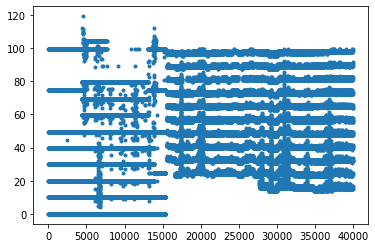

In [6]:
plt.plot(df.DEPTH.values[:40000],'.')

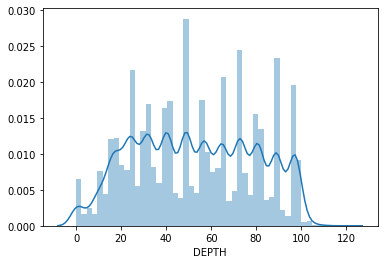

In [7]:
#get distribution of depths
sns.distplot(df['DEPTH'].dropna())

In [14]:
#binned = pd.cut(x=df.DEPTH, bins=[0, 30, 60,80, np.inf], right=False, labels=['surface', '30-60', '60-80' , 'bottom'])
binned = pd.cut(x=df.DEPTH, bins=[20, 30], right=False, labels=['surface'])
grouped = df.groupby(binned)
surface_temp_1M = grouped.get_group('surface').TEMP.resample('1M').mean()
#bottom_temp_1M = grouped.get_group('bottom').TEMP.resample('1M').mean()

In [15]:
# # Compute the centered 1-year rolling mean
# surface_temp_1Y = surface_temp_1M.rolling(12, center=True,min_periods=1).mean()
# bottom_temp_1Y = bottom_temp_1M.rolling(12, center=True,min_periods=1).mean()

# #Compute the centered 10-year rolling mean
# surface_temp_5Y = surface_temp_1M.rolling(60, center=True, win_type='hamming',min_periods=10).mean()
# bottom_temp_5Y = bottom_temp_1M.rolling(60, center=True, win_type='hamming',min_periods=10).mean()

NameError: name 'surface_temp_1Y' is not defined

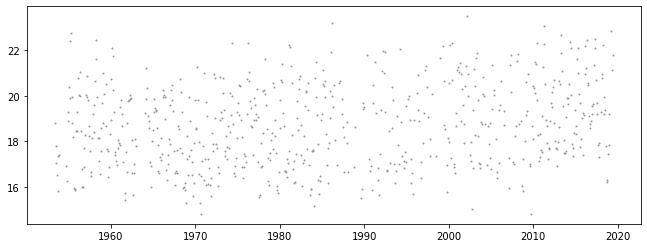

In [16]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1M, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(surface_temp_1Y, linewidth=2, label='monthly mean')
ax.plot(surface_temp_5Y, color='0.2', linewidth=3, label='Trend (5yr Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
plt.ylim(12, 24)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('0-30m Temperature at PH 100');

NameError: name 'bottom_temp_1M' is not defined

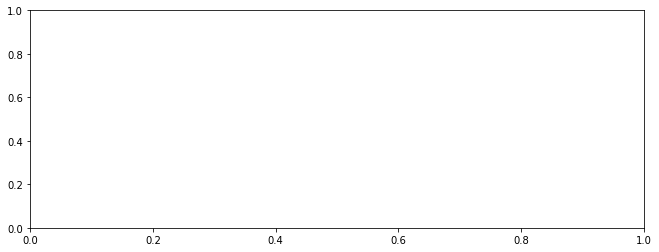

In [17]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(bottom_temp_1M, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(bottom_temp_1Y, linewidth=2, label='monthly mean')
ax.plot(bottom_temp_5Y, color='0.2', linewidth=3, label='Trend (5yr Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
plt.ylim(12, 24)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at PH 100');

## Now lets use the stasmodels api to decompose the timeseries

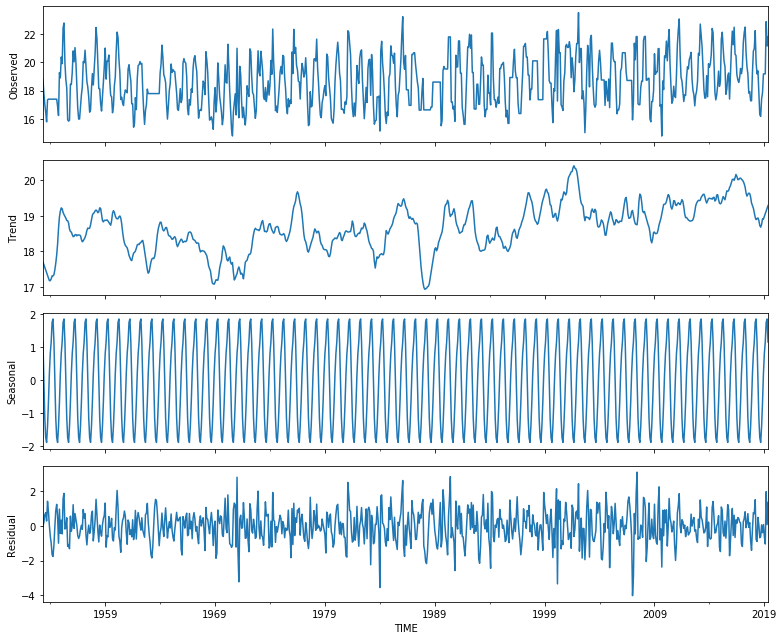

In [18]:
plt.rcParams['figure.figsize'] = 11, 9

y = surface_temp_1M.fillna(surface_temp_1M.ffill())
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq=12 ,extrapolate_trend=1)
fig = decomposition.plot()
plt.show()

## Let's look at the frequency of these diffierent components

Text(0.5, 1.0, 'PH 100 0:30m temperature')

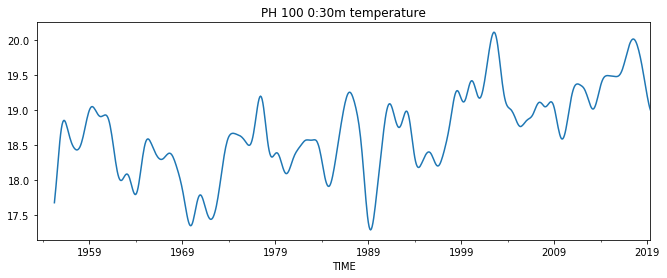

In [19]:
plt.rcParams['figure.figsize'] = 11, 4
annual_trend = decomposition.trend.rolling(24, win_type='hamming').mean().plot()
plt.title('PH 100 0:30m temperature')